In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A model of a heat jacket

In this notebook we analyze the behavior of a tank containing liquid heated with an electric heater and cooled with an external heat jacket. The contents of the vessel are thouroughly mixed, the same holds for the heat jacket (external recirculation pump). Under these conditions we can set up the following energy balances:

$$M C_\mathrm{p} \frac{dT}{dt} = UA(T_\mathrm{j} - T) + Q$$
$$m C_\mathrm{p,j} \frac{dT_\mathrm{j}}{dt} = UA(T-T_\mathrm{j}) + u_\mathrm{v} \dot{m} C_\mathrm{p,j} (T_{\mathrm{j},0} - T_\mathrm{j})$$

We are interested whether it is possible to reconstruct the state variables if only one of the temperatures is measured. First we write the system in linear state-space form (assuming that the valve remains at a fixed position for the duration of the process):

$$\begin{bmatrix}
\dot{T} \\
\dot{T_\mathrm{j}}
\end{bmatrix} = 
\begin{bmatrix}
-\frac{UA}{M C_\mathrm{p}} & \frac{UA}{M C_\mathrm{p}} \\
\frac{UA}{m C_\mathrm{p,j}} & -\left(\frac{UA}{m C_\mathrm{p,j}} + u_\mathrm{v} \frac{\dot{m}}{m}\right)
\end{bmatrix}
\begin{bmatrix}
T \\
T_\mathrm{j}
\end{bmatrix} +
\begin{bmatrix}
\frac{1}{M C_\mathrm{p}} \\ 
0
\end{bmatrix} Q +
\begin{bmatrix}
0 \\
u_\mathrm{v} \frac{\dot{m}}{m} T_{\mathrm{j},0}
\end{bmatrix}$$

The measurement equation is given by

$$y = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
T \\
T_\mathrm{j}
\end{bmatrix}$$

The LTI system above is still continous. For our numerical experiment we will instead sample it with a discrete time step by setting

$$\begin{bmatrix}
\dot{T} \\
\dot{T_\mathrm{j}}
\end{bmatrix} \approx
\frac{1}{\Delta t}
\left(
\begin{bmatrix}
T^{k+1} \\
T_\mathrm{j}^{k+1}
\end{bmatrix} - 
\begin{bmatrix}
T^k \\
T_\mathrm{j}^k
\end{bmatrix}\right)
$$

and substituting the approximation into the equation above to obtain

$$\begin{bmatrix}
T^{k+1} \\
T_\mathrm{j}^{k+1}
\end{bmatrix} =  
\begin{bmatrix}
-\Delta t\frac{UA}{M C_\mathrm{p}} + 1 & \Delta t\frac{UA}{M C_\mathrm{p}} \\
\Delta t\frac{UA}{m C_\mathrm{p,j}} & -\Delta t\left(\frac{UA}{m C_\mathrm{p,j}} + u_\mathrm{v} \frac{\dot{m}}{m}\right) + 1
\end{bmatrix}
\begin{bmatrix}
T^k \\
T_\mathrm{j}^k
\end{bmatrix} +
\begin{bmatrix}
\frac{\Delta t}{M C_\mathrm{p}} \\ 
0
\end{bmatrix} Q + 
\begin{bmatrix}
0 \\
\Delta t u_\mathrm{v} \frac{\dot{m}}{m} T_{\mathrm{j},0}
\end{bmatrix}$$


Let's try to do this in code now!


In [2]:
M = 100          # kg
Cp = 4200        # J kg^-1 K^-1

U = 400          # W m^-2 K^-1
As = 0.3         # m^2

m = 20           # kg
Cpj = 3500       # J kg^-1 K^-1

uv = 0.5
mdot = 800./3600 # kg s^1

Tj0 = 273 - 10   # K

Qm = 100         # W

dt = 0.1 # 


# State matrix
A = np.array([[-dt*U*As/(M*Cp) + 1, dt*U*As/(M*Cp)],
              [dt*U*As/(m*Cpj), -dt*(U*As/(m*Cpj) + uv*mdot/m) + 1]])


B = np.array([dt/M/Cp,0])

u = Qm

C = np.array([0,dt*uv*mdot/m*Tj0])

D = np.array([0, 1])



In [3]:
tmax = 100*60
time = np.arange(0,tmax,dt)

# state and measurement arrays
x = np.empty((2,len(time)))
y = np.empty((1,len(time)))

# inital state
T0 = 273 + 80 
TRM = 273 - 10
x[:,0] = np.asarray([T0, TRM])
y[:,0] = D.dot(x[:,0])

# simulation
for i in range(1,len(time)):
    x[:,i] = A.dot(x[:,i-1]) + B.dot(u) + C
    y[:,i] = D.dot(x[:,i])

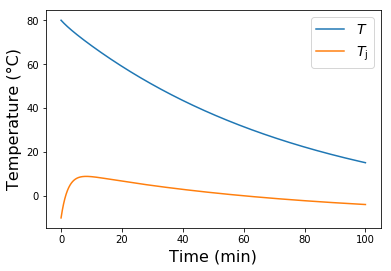

In [4]:
plt.plot(time/60,x[0,:]-273,'-',label=r"$T$")
plt.plot(time/60,x[1,:]-273,'-',label=r"$T_\mathrm{j}$")
plt.xlabel(r"Time (min)",fontsize=16)
plt.ylabel(r"Temperature (°C)",fontsize=16)
plt.legend(loc=0,fontsize=14)
plt.show()

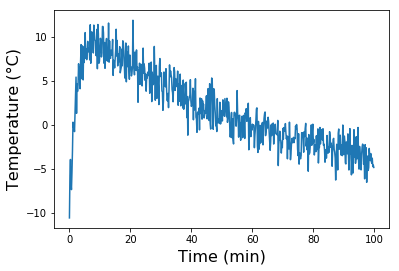

In [5]:
observation_noise = 1.5
measurements = y[0,::100] + np.random.normal(0,observation_noise,y[0,::100].shape)
meas_time = time[::100]

plt.plot(meas_time/60,measurements - 273,'-',label="measurements")
plt.xlabel(r"Time (min)",fontsize=16)
plt.ylabel(r"Temperature (°C)",fontsize=16)
plt.show()

In [6]:
dt = 10.
ftime = np.arange(0,tmax,dt)

# State matrix
A = np.array([[-dt*U*As/(M*Cp) + 1, dt*U*As/(M*Cp)],
              [dt*U*As/(m*Cpj), -dt*(U*As/(m*Cpj) + uv*mdot/m) + 1]])

B = np.array([dt/M/Cp,0])

u = Qm

C = np.array([0,dt*uv*mdot/m*Tj0])

In [7]:
A

array([[0.99714286, 0.00285714],
       [0.01714286, 0.92730159]])

In [8]:
# state and measurement arrays
xf = np.empty((2,len(ftime)))
yf = np.empty((1,len(ftime)))

T0 = 273 + 80 
TRM = 273 + 20
xf[:,0] = np.asarray([T0, TRM])


In [9]:
evolution_noise = 0.1
Q = evolution_noise*np.eye(2)

sigmaT = 1.
sigmaTj = 10.
P = A.dot(np.diag([sigmaT,sigmaTj]).dot(A.T))
R = observation_noise*np.eye(1)

In [10]:
for i in range(1,len(ftime)):

    # Prediction step
    # ---------------------
    # Project state and error covariance
    xtemp = A.dot(xf[:,i-1]) + B.dot(u) + C
    P = A.dot(P).dot(A.T) + Q

    # Correction step
    # ---------------------
    # Compute Kalman gain
    K = P.dot(D.T).dot(np.linalg.pinv((D.dot(P).dot(D.T))+ R)[0,0]) # hack
    # Update estimate via measurement
    xf[:,i] = xtemp + K.dot(measurements[i] - D.dot(xtemp))
    # Update error covariance
    P = P - K.dot(D.dot(P))

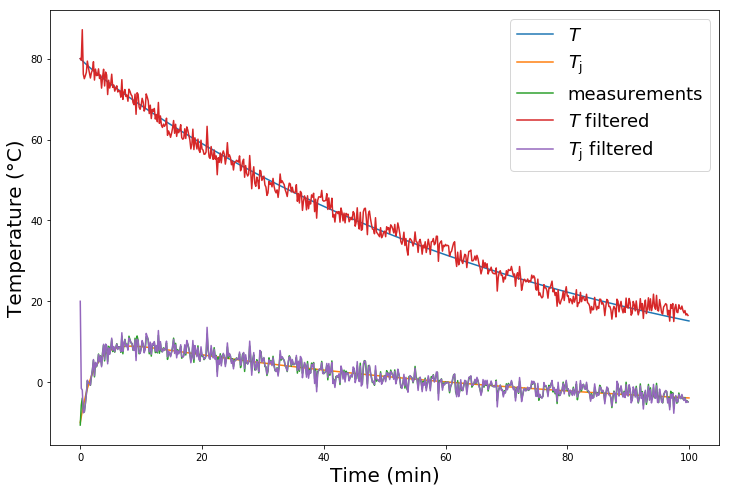

In [15]:
plt.figure(figsize=(12,8))
plt.plot(time/60,x[0,:]-273,'-',label=r"$T$")
plt.plot(time/60,x[1,:]-273,'-',label=r"$T_\mathrm{j}$")
plt.plot(meas_time/60,measurements - 273,'-',label=r"measurements")
plt.plot(ftime/60,xf[0,:] - 273,'-',label=r"$T$ filtered")
plt.plot(ftime/60,xf[1,:] - 273,'-',label=r"$T_\mathrm{j}$ filtered")

#plt.title("Filtered temperature from jacket")
plt.xlabel(r"Time (min)",fontsize=20)
plt.ylabel(r"Temperature (°C)",fontsize=20)
plt.legend(loc=0,fontsize=18)
plt.savefig("only_jacket.png",dpi=400,transparent=True)
plt.show()

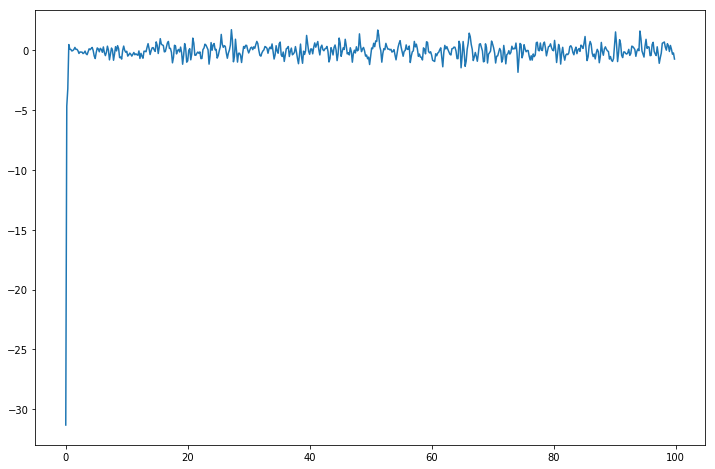

In [360]:
plt.figure(figsize=(12,8))
plt.plot(meas_time/60,measurements - xf[1,:],'-',label=r"measurements")

## Measuring the heat generation from the heat jacket

In [375]:
dt = 10.
ftime = np.arange(0,tmax,dt)

# State matrix
A = np.array([[-dt*U*As/(M*Cp) + 1, dt*U*As/(M*Cp),dt/(M*Cp)],
              [dt*U*As/(m*Cpj), -dt*(U*As/(m*Cpj) + uv*mdot/m) + 1, 0],
              [0,0,1]])


C = np.array([0,dt*uv*mdot/m*Tj0,0])

D = np.asarray([0,1,0])

In [376]:
# state and measurement arrays
xf = np.empty((3,len(ftime)))
yf = np.empty((1,len(ftime)))

T0 = 273 + 80 
TRM = 273 + 20
Q0 = 0.0
xf[:,0] = np.asarray([T0, TRM,Q0])

In [377]:
evolution_noise = 0.1
Q = evolution_noise*np.eye(3)

sigmaT = 1.
sigmaTj = 10.
sigmaQ = 1.
P = A.dot(np.diag([sigmaT,sigmaTj,sigmaQ]).dot(A.T))
R = observation_noise*np.eye(1)

In [378]:
for i in range(1,len(ftime)):

    # Prediction step
    # ---------------------
    # Project state and error covariance
    xtemp = A.dot(xf[:,i-1]) + C
    P = A.dot(P).dot(A.T) + Q

    # Correction step
    # ---------------------
    # Compute Kalman gain
    K = P.dot(D.T).dot(np.linalg.pinv((D.dot(P).dot(D.T))+ R)[0,0]) # hack
    # Update estimate via measurement
    xf[:,i] = xtemp + K.dot(measurements[i] - D.dot(xtemp))
    # Update error covariance
    P = P - K.dot(D.dot(P))

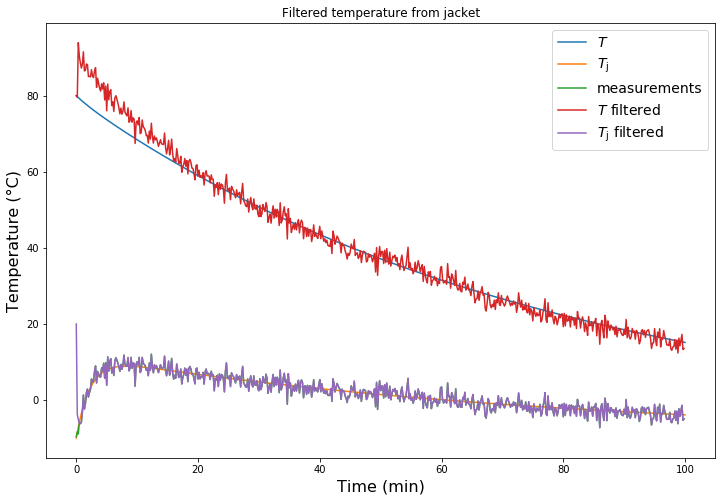

In [379]:
plt.figure(figsize=(12,8))
plt.plot(time/60,x[0,:]-273,'-',label=r"$T$")
plt.plot(time/60,x[1,:]-273,'-',label=r"$T_\mathrm{j}$")
plt.plot(meas_time/60,measurements - 273,'-',label=r"measurements")
plt.plot(ftime/60,xf[0,:] - 273,'-',label=r"$T$ filtered")
plt.plot(ftime/60,xf[1,:] - 273,'-',label=r"$T_\mathrm{j}$ filtered")

plt.title("Filtered temperature from jacket")
plt.xlabel(r"Time (min)",fontsize=16)
plt.ylabel(r"Temperature (°C)",fontsize=16)
plt.legend(loc=0,fontsize=14)
plt.show()

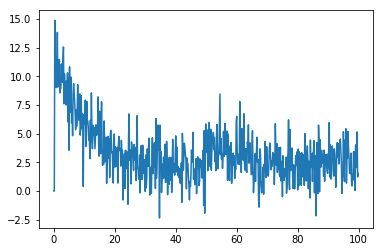

In [382]:
plt.figure()
plt.plot(ftime/60,xf[2,:],'-',label=r"$T$")